In [46]:
import torch
from torch import nn as nn
from torch.nn import functional as F
import torch.optim as optim
from torch.nn.modules.linear import Linear
from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# TP 6 : feedforward neural network

Ce TP sera noté:
- le notebook jupiter complet `tp6.ipybn` doit être rendu sur moodle au plus tard le dimanche 20 février à 20h,
- le TP est à faire tout seul ou en binôme, il est strictement interdit de travailler en plus de deux sur un même fichier, 
- éviter de chercher du code sur internet, **toute source extérieure doit être explicitement mentionnée**, 
- tout plagiat avéré sera sanctionné. 
  
Une soutenance par binôme en distanciel sera organisée la semaine du 21 au 25 février par rendez-vous. 
La note sera sur cinq niveaux (A, B, C, D, E): **il ne s'agit pas du projet final du cours** (ce dernier sera donné plus tard). La notation de ce TP jouera un rôle très relatif sur la notation finale de l'UE: son but est surtout de vous donner des retours individuels sur votre avancement. 

Identifiants du binôme:

  1. membre du groupe:
   - NOM: HENNI                  
   - PRÉNOM: Amar            
   


## Réchauffement avec le TP 3

Dans cette section, nous reprenons le jeu de données des exercices 9 et 10 du TP3 et nous allons construire un réseau à deux couches qui classifie ces données.  

### Exercice 1 (préparation du jeu de données)

Téléchargez depuis moodle le fichier ```database.pt``` contenant un jeu de données de 3000 points dans la region $[-1,1]^2$ du plan cartésien, repartis en trois classes $0$, $1$ et $2$. Affichez ce jeu de données en récupérant le code nécessaire depuis le TP3 pour visualiser les points avec la fonction ```show_data```. 

In [47]:
# visualisation data and model
def show_data(data_inputs, data_labels, model=None):
    zeros = ([x[0] for x,l in zip(data_inputs, data_labels) if l == 0], [x[1] for x,l in zip(data_inputs, data_labels) if l == 0])
    ones = ([x[0] for x,l in zip(data_inputs, data_labels) if l == 1], [x[1] for x,l in zip(data_inputs, data_labels) if l == 1])
    twos = ([x[0] for x,l in zip(data_inputs, data_labels) if l == 2], [x[1] for x,l in zip(data_inputs, data_labels) if l == 2])
    fig, ax = plt.subplots()
    if model is not None: # for plotting decision boundary of the model
        step = 0.02
        xx, yy = torch.meshgrid(torch.arange(-1.0, 1.1, step), torch.arange(-1.0, 1.1, step), indexing='ij')
        labels = model(torch.column_stack((xx.ravel(),yy.ravel())))
        labels = (labels > 0.5)
        plt.pcolormesh(xx, yy, labels.reshape(xx.shape), alpha=0.7, shading='auto')
    ax.scatter(twos[0], twos[1], c='green', edgecolor="white", linewidth=1)
    ax.scatter(ones[0], ones[1], c='blue', edgecolor="white", linewidth=1)
    ax.scatter(zeros[0], zeros[1], c='red', edgecolor="white", linewidth=1)        
    plt.show()
  
def show_learning(history):
  fig, ax = plt.subplots()
  ax.plot([h['epoch'] for h in history], [h['loss'] for h in history], label='loss')
  ax.plot([h['epoch'] for h in history], [h['train_acc'] for h in history], label='train accuracy')
  ax.plot([h['epoch'] for h in history], [h['validation_acc'] for h in history], label='test accuracy')
  plt.legend()
  plt.show()

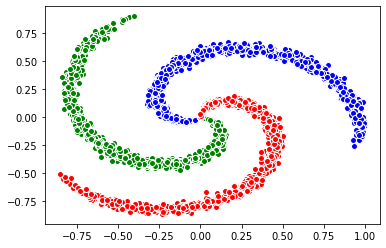

In [48]:
# STUDENT, THIS IS YOUR JOB!
data_inputs, data_labels = torch.load('./drive/MyDrive/data/database.pt')
show_data(data_inputs,data_labels)

Pour être sur que les échantillons ont une distribution uniforme sur des tranches, mélangez le jeu de données en utilisant la fonction `torch.randperm`, ensuite séparez ce jeu en "training data-set" et "validation data-set", avec une répartition de, respectivement, 80% de données pour le premier et 20% de données pour le deuxième. 

In [49]:
# STUDENT, THIS IS YOUR JOB!
permutation = torch.randperm(len(data_inputs))
data_inputs, data_labels = data_inputs[permutation], data_labels[permutation]
# now I can split
split = 8 * (len(data_inputs)) // 10 # 80% training, 20% validation
train_inputs = data_inputs[:split]
train_labels = data_labels[:split]
validation_inputs = data_inputs[split:]
validation_labels = data_labels[split:]


### Exercice 3

Définissez un réseau de neurones avec deux couches (layer en anglais), à vous de choisir de bonnes fonctions d'activation. Faites apprendre ce réseau sur le jeu de données ci-dessus. Quelle fonction de perte pensez vous d'utiliser ? Trouvez les bons paramètres pour obtenir un taux d'exactitude sur le "validation data-set" supérieur à 99%. 

In [50]:
# STUDENT, THIS IS YOUR JOB !
class FeedForward(nn.Module):
    def __init__(self,num_features):
        super(FeedForward, self).__init__()                     
        self.fct1 = Linear(num_features, (num_features*3)**2, bias=True)  
        self.fct2 = Linear((num_features*3)**2, 3, bias=True)  
    
    def forward(self, input):
      x1 = self.fct1(input)
      layer1 = F.relu(x1)
      x2 = self.fct2(layer1)
      output = F.softmax(x2, dim=1)
      return output

model = FeedForward(2)
print(model(train_inputs[:5])) # inputs [(x,y),...] -> [[distribution uniforme]]


tensor([[0.4275, 0.3256, 0.2469],
        [0.3880, 0.3507, 0.2613],
        [0.4272, 0.3258, 0.2470],
        [0.3781, 0.3569, 0.2650],
        [0.4328, 0.3189, 0.2483]], grad_fn=<SoftmaxBackward0>)


In [51]:
def learning_process(model, loss_function, lr=1, n_epochs=200, accuracy=None):
    history = []    # to monitor learning 
    for epoch in range(n_epochs):    
        predictions = model(train_inputs)
        loss = loss_function(predictions, train_labels)
        model.zero_grad()
        loss.backward()
        with torch.no_grad():
            for p in model.parameters():
                p -= lr*p.grad

            if epoch % 10 == 0: # to monitor learning
                train_acc = accuracy(predictions, train_labels) 
                validation_acc = accuracy(model(validation_inputs), validation_labels) 
                history.append({
                    'epoch':epoch, 
                    'loss':loss.detach().numpy(), 
                    'train_acc': train_acc, 
                    'validation_acc': validation_acc
                })
                print(f"epoch {epoch+1}/{n_epochs},\t loss = {loss.detach().numpy()}")        
    return history
  
def accuracy(predictions, labels):
  # PREDICTION IS TRIPLET
  predictions = predictions.argmax(1) # exemple : [0.3, 0.2, 0.5] -> 2
  n_correct = (predictions == labels).sum().detach().numpy()
  return n_correct / len(labels)

In [52]:
model = FeedForward(2)
history = learning_process(
    model=model, 
    loss_function=F.cross_entropy, 
    lr=0.5,
    n_epochs=5000,
    accuracy=accuracy)

epoch 1/5000,	 loss = 1.0862548351287842
epoch 11/5000,	 loss = 1.0344587564468384
epoch 21/5000,	 loss = 0.9961158037185669
epoch 31/5000,	 loss = 0.9681355953216553
epoch 41/5000,	 loss = 0.9476594924926758
epoch 51/5000,	 loss = 0.9329683184623718
epoch 61/5000,	 loss = 0.9224965572357178
epoch 71/5000,	 loss = 0.9148647785186768
epoch 81/5000,	 loss = 0.9090773463249207
epoch 91/5000,	 loss = 0.9044638276100159
epoch 101/5000,	 loss = 0.900602400302887
epoch 111/5000,	 loss = 0.8972437381744385
epoch 121/5000,	 loss = 0.8941935300827026
epoch 131/5000,	 loss = 0.8913808465003967
epoch 141/5000,	 loss = 0.8887457251548767
epoch 151/5000,	 loss = 0.8862045407295227
epoch 161/5000,	 loss = 0.8837071657180786
epoch 171/5000,	 loss = 0.8812192678451538
epoch 181/5000,	 loss = 0.8787169456481934
epoch 191/5000,	 loss = 0.8761757612228394
epoch 201/5000,	 loss = 0.8735901713371277
epoch 211/5000,	 loss = 0.8709418773651123
epoch 221/5000,	 loss = 0.8682237863540649
epoch 231/5000,	 loss =

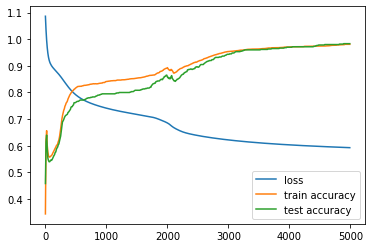

accuracy :  0.9833333333333333


In [53]:
show_learning(history)
print("accuracy : ",accuracy(model(validation_inputs), validation_labels)) 

## Deviner le prochain mot

Dans cette section, nous allons construire un réseau de neurones multicouche qui apprend des mots en anglais. À ce fin, nous allons entraîner le réseau pour qu'il prend en entrée une sequence des (indices des) mots et donne en sortie une distribution de probabilité sur le mot qui vient après.  

Il s'agit d'un modèle simple mais avec une multitude d'applications, comme la reconnaissance vocale, la correction automatique, la traduction de langues etc.. Pour votre curiosité vous trouverez une excellente introduction à ce modèle ici: [Speech and Language Processing](https://web.stanford.edu/~jurafsky/slp3/3.pdf).

Ces exercices sont une variante du mini-projet du cours d'introduction à l'apprentissage de [Geoffrey Hinton](https://en.wikipedia.org/wiki/Geoffrey_Hinton) de l'Université de Toronto, dont vous trouverez une description ici: [CSC 321: Assignment 1](https://www.cs.toronto.edu/~yaojian/csc321/assignment1.html).

### Exercice 4 (création des grams)

Téléchargez le fichier `raw_sentences.txt` et explorez-le avec un éditeur de texte. Le fichier contient des phrases qui seront utilisées pour faire apprendre notre modèle. Ces phrases sont particulièrement simples et basées sur un vocabulaire d'environ $250$ mots. Le première exercice consiste à extraire des séquences de 4 mots adjacents, appelées *4-grams*.

Quelque convention que nous avons décidé d'adopter:
- deux mots sur deux lignes différentes ne seront pas considérés comme adjacents;
- nous ne faisons pas de différence entre lettres minuscules et majuscules;
- nous prenons en considération la punctuation.

Créer une liste `grams` des couples `(context, target)` telle que `context` est une liste de trois mots adjacents et `target` est le mot suivant à ces trois mots. Par exemple, les premières dix éléments de `grams` sont (dans notre implémentation): 

        [(['no', ',', 'he'], 'says'),
        ([',', 'he', 'says'], 'now'),
        (['he', 'says', 'now'], '.'),
        (['and', 'what', 'did'], 'he'),
        (['what', 'did', 'he'], 'do'),
        (['did', 'he', 'do'], '?'),
        (['the', 'money', "'s"], 'there'),
        (['money', "'s", 'there'], '.'),
        (['that', 'was', 'less'], 'than'),
        (['was', 'less', 'than'], 'a')]

Cette liste a une longueur totale de `465678` grams. 


In [54]:
def four_grams(filepath):
  result = list()
  with open(filepath, 'r') as file:
    for line in file.readlines():
      words = line.lower().split()
      for i in range(3,len(words)):
        result.append((words[i-3:i],words[i]))
  return result


In [55]:
# STUDENT, THIS IS YOUR JOB!
sentences = four_grams('./drive/MyDrive/data/raw_sentences.txt')
for gram in sentences[:10] : print(gram)

print("Longueur totale : ",len(sentences))


(['no', ',', 'he'], 'says')
([',', 'he', 'says'], 'now')
(['he', 'says', 'now'], '.')
(['and', 'what', 'did'], 'he')
(['what', 'did', 'he'], 'do')
(['did', 'he', 'do'], '?')
(['the', 'money', "'s"], 'there')
(['money', "'s", 'there'], '.')
(['that', 'was', 'less'], 'than')
(['was', 'less', 'than'], 'a')
Longueur totale :  465686


### Exercice 5 (transformation de `grams` en tenseurs)

Les éléments `context` des couples des `grams` constituerons notre tenseur `inputs`, contenant les "features" du problème, alors que les éléments `target` donnent un tenseur `targets`, utilisé comme guide pour l'apprentissage du modèle. À cette fin, nous devons associer à chauqe mot un entier unique, appellé `idx`, qui nous permettra de travailler avec des tenseur de type `torch.long`. 

Créez le vocabulaire du jeu de données, cet-à dire l'ensemble des mots utilisés par `grams`. Il devrait avoir `249` mots. Créez deux dictionnaires `idx_from_word` et `word_from_idx` permettant d'associer un entier à un mot de façon unique (et vice-versa) en utilisant une énumération du vocabulaire. 

En utilisant ces dictionnaires et `grams` définissez donc les tenseurs `inputs` et `targets`. Ils devront avoir forme respectivement `[465678, 3]` et `[465678]`. 

Mélangez leur éléments en utilisant une même permutation pour les deux et départagez les deux tenseurs dans un "training data-set" et un "validation data-set" en proportion environ de 80% et 20% du jeu de données. 

In [56]:
# STUDENT, THIS IS YOUR JOB
def getDictionariesFrom(filepath):
  idx_from_word = dict()
  word_from_idx = dict()
  id = 0
  with open(filepath, 'r') as file:
    for line in file.readlines():
      words = line.lower().split()
      for word in words:
        if not word in word_from_idx :
          word_from_idx[word] = id
          idx_from_word[id] = word
          id += 1
  return idx_from_word, word_from_idx

def toTensor(filepath, sentences):
  _ ,  word_from_idx = getDictionariesFrom(filepath)
  inputs = list()
  targets = list()
  for sentence in sentences : 
    input, target = sentence
    inputs.append([word_from_idx[word] for word in input])
    targets.append(word_from_idx[target])
  return torch.tensor(inputs), torch.tensor(targets)

In [57]:
inputs,  targets = toTensor('./drive/MyDrive/data/raw_sentences.txt', sentences)

print(inputs.shape)
print(targets.shape)

torch.Size([465686, 3])
torch.Size([465686])


In [58]:
permutation = torch.randperm(len(inputs))
inputs, targets = inputs[permutation], targets[permutation]
# now I can split
split = 8 * (len(inputs)) // 10 # 80% training, 20% validation
train_inputs = inputs[:split]
train_targets = targets[:split]
validation_inputs = inputs[split:]
validation_targets = targets[split:]

### Exercice 6 (creation d'un data-loader)

Il est pratique d'avoir un "training" et un "validation" data-loader pour permettre d'expérimenter rapidement la descente du gradient avec des batch différents. Definissez donc une classe dédiée qui hérite du `Dataset` et utilisez la pour construire deux instances de `DataLoader`, une dédiée aux  "training", l'autre au "validation".

(*Suggestion: n'hésitez pas à revoir les transparents du CMTP5 détaillant comment définir des nouveaux `DataLoader`)

In [59]:
class MyDataSet(Dataset):
  def __init__(self, inputs, targets):
    self.inputs = inputs
    self.labels = targets
  
  def __len__(self):
    return len(self.inputs)

  def __getitem__(self, index):
    return self.inputs[index], self.labels[index]

In [60]:
train_loader = DataLoader(
    MyDataSet(train_inputs, train_targets),
    batch_size=128
)

validation_loader = DataLoader(
    MyDataSet(validation_inputs, validation_targets),
    batch_size=128
)

### Exercice 7 (definition du modèle multi-couche)

Vous devez définir un réseau de neurones qui se compose de $4$ couches:
1. une couche d'entrée, qui prend en entrée trois `idx` de mots;
2. une couche d'"*immersion*" qui donne une représentation interne du modèle des caractéristiques sémantiques des mots, en associant à chaque `idx` des mots un tenseur de flottants de dimension `d_dist_repr` (nous pouvons essayer `d_dist_repr = 8`, `d_dist_repr = 16` ou `d_dist_repr = 32`). Les neurones reliant la couche d'entrée à la couche d'"*immersion*" transforment donc le type `long` des `idx` au type `float`: vous pouvez le faire en utilisant le "one-hot encoding" des `idx` et ensuite un module `nn.Linear`, ou bien en utilisant directement le module `nn.Embedding` de PyTorch (voir API). Il est importante que les trois `idx` soient transformés en utilisant **le même ensemble de paramètres** pour mapper chaque indice de la couche d'entrée dans la couche d'"*immersion*";  
3. une couche cachée qui est une couche linéaire de dimension `d_hidden` (nous essayerons par exemple `d_hidden = 64` et `d_hidden = 256`) avec activation à votre choix; 
4. une couche de sortie, qui donne une distribution de probabilité sur les mots du vocabulaire, donnant le mot suivant du gram passé en entrée. Vous pouvez considérer deux possibles fonctions d'activation: `softmax` et `log_softmax`. (Attention, vous allez voir dans l'apprentissage qu'une des deux activations marche nettement mieux que l'autre, savez vous dire pour quelle raison ?).

La création du réseau doit être paramétrisé par `n_words` (les nombres des mots dans le vocabulaire), `d_context` (le nombre de mots dans un échantillon de `inputs`, dans notre cas $3$), `d_dist_repr` (la dimension de la couche d'"*immersion*") et par `d_hidden` (la dimension de la couche interne au modèle). 

(*Attention, une spécificité de ce modèle par rapport à l'architecture feedforward standard est que la couche d'"*immersion*" est calculée avec la même transformation linéaire sur les trois indices d'entrée. En effet, la couche interne aurait `d_context * d_dist_repr` neurones en entrée et sortira avec `d_hidden` connections. À cette fin, il faudrait modifier la forme de la sortie du premier module de neurones, en ayant `d_context` et `d_dist_repr` sur deux axes distinctes.*)


In [66]:
# STUDENT, THIS IS YOUR JOB
class WordPredict(nn.Module):
  """
    n_words : les nombres des mots dans le vocabulaire
    d_context : le nombre de mots dans un échantillon de inputs, dans notre cas  3
    d_dist_repr : la dimension de la couche d'"immersion"
    d_hidden : la dimension de la couche interne au modèle
  """
  def __init__(self,n_words,d_context,d_dist_repr,d_hidden):
    super(WordPredict, self).__init__()                     
    self.embadding = nn.Embedding(n_words, d_dist_repr)   # trois idx soient transformés en utilisant le même ensemble de paramètres
    self.fct1 = Linear(d_dist_repr, d_hidden, bias=True)
    self.fct2 = Linear(d_hidden, n_words, bias=True)  

  def forward(self, input):
    emb          = self.embadding(input)
    layer1       = F.relu(torch.flatten(emb,end_dim=1))
    hidden_layer = F.relu(self.fct1(layer1))
    output       = F.log_softmax(self.fct2(hidden_layer),dim=1)
    return output 

model = WordPredict(250,3,16,48)
model(train_inputs[0:3])

tensor([[-5.4196, -5.7149, -5.3213,  ..., -5.7261, -5.6351, -5.7329],
        [-5.2567, -5.7961, -4.9743,  ..., -5.4116, -5.5494, -5.3992],
        [-5.5418, -5.8964, -5.3482,  ..., -5.9446, -5.7742, -5.7137],
        ...,
        [-5.4237, -5.7937, -5.3649,  ..., -5.6343, -5.4481, -5.5192],
        [-5.4641, -5.6905, -5.2917,  ..., -5.3718, -5.3272, -5.3432],
        [-5.4370, -5.8311, -5.3160,  ..., -5.6589, -5.4821, -5.3336]],
       grad_fn=<LogSoftmaxBackward0>)

### Exercice 8 (apprentissage)

Faites apprendre votre modèle en utilisant l'optimiseur `Adam` et comme fonction de perte `nn.CrossEntropyLoss` ou `nn.NLLoss` (voir API), selon la fonction d'activation choisie pour la couche de sortie. Pour peaufiner les hyperparametres de votre apprentissage il faut choisir une notion de taux d'exactitude (ou d'erreur). En effet il ne s'agit pas vraiment d'un problème de classification, mais plutôt d'un problème d'estimation d'une distribution probabiliste. Dans ce cas vous pouvez utiliser la même fonction de perte (mais sur le "validation data-set") pour évaluer la performance de vos hyperparametres. 

Trouvez un bon taux d'apprentissage (*learning rate*) et nombre d'époques. Combien de paramètres a votre modèle ? Avec cette dimension l'utilisation des GPU deviennent utile, voir indispensable. Malheureusement, la disponibilité  de la mémoire RAM pour les comptes gratuits de colab peut être limitative. La quantité de RAM de colab accessible varie selon le nombre d'utilisateurs... d'après mon expérience, tôt le matin (par exemple vers 7 heures), colab vous offre pas mal des ressources. Si par contre vous n'aimez pas trop vous levez tôt, vous pouvez vous rappeler que faire des batches aide à limiter beaucoup l'utilisation de la RAM... 

Vous pouvez aussi expérimenter et choisir entre différentes variants d'algorithme de la descente du gradient, comme le "gradient descent with batches" ou le "stochastic mini-batch gradient descent" (voir transparents CMTP5). 

Vous pouvez aussi sauvegarder et télécharger les paramètres du modèle après l'apprentissage (voir [API](https://pytorch.org/tutorials/beginner/saving_loading_models.html#saving-and-loading-models)) pour le tester directement sur votre machine. Attention, l'accès aux GPU des colab est instable et il peut s'interrompre après un délais d'attente trop longue ou le dépassement des limites d'utilisation de la mémoire. Nous vous conseillons donc de télécharger les paramètres de votre modèle toujours sur votre machine locale. 

In [67]:
def train_loop(train_loader, model, loss_map,lr=0.06,epochs=15):
    # use gpu if available
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(device)
    model.to(device)
    
    # create optimizer
    optimizer = optim.Adam(model.parameters(), lr=lr)

    history_loss = []

    # Train model
    for epoch in range(epochs):
        loss_epoch = 0.
        for images, labels in train_loader:
            # Transfers data to GPU
            images, labels = images.to(device), labels.to(device)
            # Primal computation
            output = model(images)            
            loss = loss_map(output, labels)            
            # Gradient computation
            model.zero_grad()
            loss.backward()
            # perform parameter update based on current gradients
            optimizer.step()
            # compute the epoch training loss
            loss_epoch += loss.item()
            
        # display the epoch training loss
        print(f"epoch : {epoch + 1}/{epochs}, loss = {loss_epoch:.6f}")  
        history_loss.append(loss_epoch)
    return history_loss

Une fois que votre modèle a terminé son apprentissage, vous pouvez l'exploiter pour programmer des fonctions sur votre vocabulaire. Programmez les fonctions suivantes, en utilisant le modèle en entier ou le bloc `nn.Embedding` du modèle.
- `predict_next_word(context, model)` : étant donné un triplet `context` des trois mots du vocabulaire, la fonction renvoie la mot la plus probable selon `model` qui suit ce triplet.
- `word_distance(w1, w2, model)` : étant données deux mots `w1` et `w2` du vocabulaire, la fonction renvoie la distance relative des représentations "immersion" (c.à-d. de la sortie du module `Embedding` du `model`) de cex deux mots. 
- `display_nearest_words(w, model, top)` étant donné un entier `top`, la fonction renvoie les `top` mots du vocabulaire les plus proches au mot `w` come calculé par `word_distance`.

Donnez des exemples d'utilisation de chacune de ces fonctions et n'hésitez pas à commenter leur résultat. En particulier, avez vous une intuition de quel type de distance mesure `word_distance`?

In [69]:
# STUDENT, THIS IS YOUR JOB!
idx_from_word, word_from_idx = getDictionariesFrom('./drive/MyDrive/data/raw_sentences.txt')

def predict_next_word(context, model):
  context_idx = torch.tensor([
    word_from_idx[context[0]],
    word_from_idx[context[1]],
    word_from_idx[context[2]],                           
  ])
  prediction = torch.argmax(model(context_idx))
  return idx_from_word[prediction.item()]

def word_distance(w1, w2, model):
  w1_idx = torch.tensor(word_from_idx[w1])
  w2_idx = torch.tensor(word_from_idx[w2])
  a = model.embadding(w1_idx)
  b = model.embadding(w2_idx)
  return torch.sqrt(sum( (b-a)**2 ))

def display_nearest_words(w, model, top):
  distances = [ (idx,word_distance(w,w2,model)) for idx,w2 in idx_from_word.items()]
  distances = sorted(distances, key = lambda x: x[1])
  return torch.tensor([ pos for pos,_ in distances[1:top+1]])